In [3]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
import cv2
from tqdm import tqdm
from skimage.color import rgb2gray
from scipy import ndimage
%matplotlib inline

import pandas as pd
import numpy as np
import pickle
from PIL import Image
import random
from skimage.feature import hog

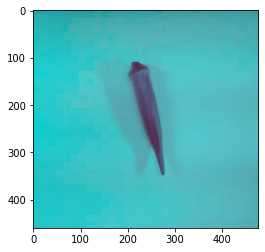

In [4]:
DATADIR = "/content/drive/My Drive/okra_image"

CATEGORIES = ["August_HLG_A", "August_HLG_B"]

for category in CATEGORIES:  
    path = os.path.join(DATADIR,category)  # create path 
    for img in os.listdir(path):  # iterate over each image 
        image = cv2.imread(os.path.join(path,img) )  # convert to array
        #plt.imshow(image, cmap='gray')  # graph it
        #plt.show()  # display!
        image.shape 
        plt.imshow(image)

        break  
    break  

In [5]:
IMG_LONG = 128
IMG_LARGE = 128

In [6]:
training_data = []

def create_training_data():
    for category in CATEGORIES:

        path = os.path.join(DATADIR,category)  
        class_num = CATEGORIES.index(category)  

        for img in tqdm(os.listdir(path)):   
            try:
                image = cv2.imread(os.path.join(path,img))                
                new_array = image
                new_array = cv2.resize(new_array,(IMG_LONG, IMG_LARGE))
                training_data.append([new_array, class_num])
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            
            
            
create_training_data()
print("")
print(len(training_data))

100%|██████████| 506/506 [06:33<00:00,  1.29it/s]


758


In [7]:
random.shuffle(training_data)
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)
X_train = np.array(X)
y_train = np.array(y)


In [ ]:
DATADIR = "/content/drive/My Drive/okra_image"

CATEGORIES = ["July_HLG_A", "July_HLG_B"]
testing_data = []

def create_testing_data():
    for category in CATEGORIES:  # do 

        path = os.path.join(DATADIR,category)  # create path
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 

        for img in tqdm(os.listdir(path)):  # iterate over each image 
            try:
                image = cv2.imread(os.path.join(path,img))                
                new_array = image
                new_array = cv2.resize(new_array,(IMG_LONG, IMG_LARGE))
                testing_data.append([new_array, class_num])
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            
            
            
create_testing_data()
print("")
print(len(testing_data))

 93%|█████████▎| 2836/3039 [35:52<02:15,  1.50it/s]

In [ ]:
random.shuffle(testing_data)
W = []
z = []
for features,label in testing_data:
    W.append(features)
    z.append(label)
X_test = np.array(W)
y_test = np.array(z)

In [ ]:
#from sklearn.model_selection import train_test_split
 
#X_train, X_test, y_train, y_test = train_test_split(
#    X,
#    y,
#    test_size=0.2,
#    shuffle=True,
#    random_state=42,
#)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
 
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
import skimage
 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(8, 8),
    cells_per_block=(2,2),
    orientations=9,
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

In [ ]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

In [ ]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

In [ ]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))